In [4]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
        print("SETTING MEMORY GROWTH")
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        
import time
import datetime

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from plot_keras_history import plot_history
import sklearn.metrics as metrics
import os as os


import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.python.client import device_lib
# import keras_tuner as kerastuner
# from keras_tuner.tuners import RandomSearch



tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

print("TF version:", tf.__version__)
print("Panda version:", pd.__version__)

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print("Physical devices: ", tf.config.list_physical_devices())
# Se va a habilitar la dedicacion dinamica de memoria para que la GPU vaya asignando recursos al proceso conforme los vaya necesitando

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
#print(tf.config.list_physical_devices('GPU'))
print("Build with CUDA: ", tf.test.is_built_with_cuda())


# Historico de datos para realizar la predicción
W = 729
# Insantes de tiempo futuros a predecir
H = 10

# Porcentaje del conjunto de test
test_size = 0.3
# Porcentaje del conjunto de validacion
val_size = 0.3

# Establecer objetivo (Name of model metric to minimize or maximize, e.g. "val_accuracy"). el "val_" hace referencia a que se coge la métrica en el subconjunto de validación

# obje = kerastuner.Objective('val_mean_absolute_percentage_error', 'min')

# Epocas
epchs=1000
# Tamaño del batch
batch = 1024
# Nodos internos
hidden_nodes = 10

# Establecer minimo y maximo de capas y el valor por defecto
minLayers = 1
maxLayers = 10
defaultLayers = 3

# Establecer medida de loss
loss="mean_squared_error"
#loss="mean_absolute_percentage_error"

# Establecer learning rate
lr = [0.0, 1e-2, 1e-3, 1e-4]

SETTING MEMORY GROWTH
TF version: 2.1.0
Panda version: 1.1.5
Physical devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Default GPU Device: /device:GPU:0
Num GPUs Available:  1
Build with CUDA:  True


In [5]:
df = pd.read_excel("C:/Users/hecto/Documents/Master/TFM/tfm-renewable-energy-deep-learning/data/2015_1min.xlsx", header=None, engine='openpyxl')[0]

print(df)
# Data preprocessing: each row will contain the 10 measures for each day , and the 10 measures for the following day
#X = pd.DataFrame(np.array(df).reshape(-1, 10), columns=["col_{}".format(i) for i in range(0, 10)])
X = pd.DataFrame(np.array(df).reshape(-1, 600))
Y = pd.DataFrame.copy(X)

Y.columns = ["col_{}".format(i) for i in range(601, 1201)]
Y = Y.drop(0)
Y = Y.reset_index(drop=True)
Y.loc[len(Y)] = np.zeros(600)

dfNoNormalized = pd.concat([X, Y], axis=1)

dataToPredict = dfNoNormalized.tail(1)
print("Row for predicting: ", dataToPredict)

print("DataFrame Preproccessed (Not Normalized):")
print(dfNoNormalized)
print("---------------------------------------------")

# Data Normalization
scaler = MinMaxScaler()
XNormalized = pd.DataFrame(scaler.fit_transform(X), columns=["col_{}".format(i) for i in range(1, 601)])
YNormalized = pd.DataFrame(scaler.fit_transform(Y), columns=["col_{}".format(i) for i in range(601, 1201)])

dfPreproccessed = pd.concat([XNormalized, YNormalized], axis=1)

# Last row is deleted beacuse it is the one for used for the real prediction, it is not useful for the training of the model.
dfPreproccessed.drop(dfNoNormalized.tail(1).index, inplace=True)
print(len(dfPreproccessed))

print("X Preproccessed:")
print(XNormalized)
print("---------------------------------------------")
print("Y Preproccessed:")
print(YNormalized)
print("---------------------------------------------")


# Split the data into training and validation sets
xTrain, xTest, yTrain, yTest = train_test_split(XNormalized, YNormalized, test_size = test_size, random_state = 0, shuffle=False)
xTrain, xVal, yTrain, yVal = train_test_split(xTrain, yTrain, test_size = val_size, random_state = 0, shuffle=False)

# Adding the third dimension needed to use LSTM (samples, timestamps, features)
xtrain = np.reshape(xTrain.values, (xTrain.shape[0], xTrain.shape[1], 1))
ytrain = np.reshape(yTrain.values, (yTrain.shape[0], yTrain.shape[1], 1))
xval = np.reshape(xVal.values, (xVal.shape[0], xVal.shape[1], 1))
yval = np.reshape(yVal.values, (yVal.shape[0], yVal.shape[1], 1))
xtest = np.reshape(xTest.values, (xTest.shape[0], xTest.shape[1], 1))
ytest = np.reshape(yTest.values, (yTest.shape[0], yTest.shape[1], 1))

# New shapes after third dimension added
print("Dimensions afther third dimension added:")
print("xTrain:\t"+str(xtrain.shape))
print("yTrain:\t"+str(ytrain.shape))
print("xVal:\t"+str(xval.shape))
print("yVal:\t"+str(yval.shape))
print("xTest:\t"+str(xtest.shape))
print("yTest:\t"+str(ytest.shape))

validation_data=xval.reshape((xval.shape[0], xval.shape[1]))

0         167.705
1         156.535
2         147.035
3         131.875
4         117.075
           ...   
218995    219.170
218996    216.610
218997    165.905
218998    174.030
218999    204.255
Name: 0, Length: 219000, dtype: float64
Row for predicting:             0        1        2        3        4        5       6        7  \
364  196.285  262.135  232.035  216.995  290.575  179.135  218.63  248.695   

           8       9  ...  col_1191  col_1192  col_1193  col_1194  col_1195  \
364  236.825  210.13  ...       0.0       0.0       0.0       0.0       0.0   

     col_1196  col_1197  col_1198  col_1199  col_1200  
364       0.0       0.0       0.0       0.0       0.0  

[1 rows x 1200 columns]
DataFrame Preproccessed (Not Normalized):
           0        1        2        3        4        5        6        7  \
0    167.705  156.535  147.035  131.875  117.075  107.105  100.345   92.940   
1     87.295   80.875   78.365   80.495   81.760   82.825  126.365  301.410   
2     34.

In [6]:
with tf.device('/gpu:0'):    
# Model definition
    model = Sequential()
    model.add(LSTM(hidden_nodes, input_shape=(xtrain.shape[1], 1)))
    model.add(Dense(600, activation="sigmoid"))

    print("Input shape", (xtrain.shape[1], 1))

    print("Summary: ")
    model.summary()

    # Model compilation
    model.compile(loss=loss,
                optimizer="adam",
                metrics=[keras.metrics.MAE, keras.metrics.MAPE, keras.metrics.MSE])

    history = model.fit(
        xtrain.reshape((xtrain.shape[0], xtrain.shape[1], 1)),
        ytrain,
        epochs=epchs,
        batch_size=batch,
        validation_data=(xval.reshape((xval.shape[0], xval.shape[1], 1)), yval))
            # validation_data=(xval,yval))

Input shape (600, 1)
Summary: 
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_1 (Dense)              (None, 600)               6600      
Total params: 7,080
Trainable params: 7,080
Non-trainable params: 0
_________________________________________________________________
Train on 178 samples, validate on 77 samples
Epoch 1/1000
178/178 [==============================] - 1s 8ms/sample - loss: 0.0651 - mean_absolute_error: 0.2158 - mean_absolute_percentage_error: 1044790.9375 - mean_squared_error: 0.0651 - val_loss: 0.0582 - val_mean_absolute_error: 0.1983 - val_mean_absolute_percentage_error: 65146.5898 - val_mean_squared_error: 0.0582
Epoch 2/1000
178/178 [==============================] - 0s 631us/sample - loss: 0.0651 - mean_absolute_error: 0.

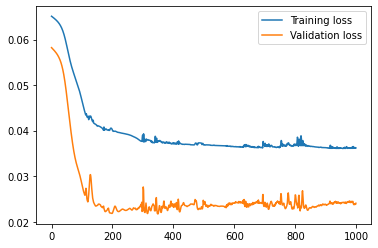

77/77 [==============================] - 0s 2ms/sample - loss: 0.0240 - mean_absolute_error: 0.1209 - mean_absolute_percentage_error: 42557.6250 - mean_squared_error: 0.0240
Score: [0.024046104594871595, 0.12091969, 42557.625, 0.024046104]


In [7]:
# Training and Validation loss curves
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# Model evaluation with validation data
score = model.evaluate(xval.reshape((xval.shape[0], xval.shape[1], 1)), yval)
print('Score:', score)